In [1]:

import rtree, pygeos
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import folium

import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta

C:\Anaconda3\envs\geo37\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [154]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [155]:

data_path = 'C:/Users/mhudgell/data/ais/'
telemetry_df = pd.read_parquet(data_path, engine='pyarrow')

In [156]:
telemetry_df =  telemetry_df[['mmsi', 'acquisition_time', 'longitude', 'latitude', 'sog', 'cog']]

In [157]:
local_df = telemetry_df[((telemetry_df['latitude'] > 51.85975370) &  (telemetry_df['latitude'] < 55.34311203)) &
                        ((telemetry_df['longitude'] > -7.33234434) & (telemetry_df['longitude'] < -2.45881019))]                


In [158]:
print(len(local_df.index), len(telemetry_df.index))

35436 12534115


In [159]:
geometry = [Point(xy) for xy in zip(local_df.longitude, local_df.latitude)]
crs = {'init': 'epsg:4326'} #4326
telemetry_gdf = gpd.GeoDataFrame(local_df, crs=crs, geometry=geometry)



C:\Anaconda3\envs\geo37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [160]:
from sklearn.cluster import DBSCAN 

clusters = DBSCAN(eps = 0.01, min_samples = 2).fit(telemetry_gdf[['longitude', 'latitude']])


In [161]:
clusters.labels_.shape

(35436,)

In [162]:
telemetry_gdf['cluster_id'] = clusters.labels_

In [163]:
telemetry_gdf['cluster_id'].describe()

count    35436.000000
mean       121.409725
std        232.444713
min         -1.000000
25%          3.000000
50%          3.000000
75%         53.000000
max        993.000000
Name: cluster_id, dtype: float64

In [164]:
telemetry_gdf

,mmsi,acquisition_time,longitude,latitude,sog,cog,geometry,cluster_id
305,219299000,2019-01-30 04:50:18,-3.228687,54.095392,0,237.3,POINT (-3.22869 54.09539),0
307,219299000,2019-01-30 13:45:03,-3.252355,53.999888,20.5,322.5,POINT (-3.25236 53.99989),-1
1853,232002727,2019-01-30 18:06:23,-4.695642,54.227368,5.2,76.7,POINT (-4.69564 54.22737),-1
1855,232002727,2019-01-30 18:22:16,-4.710313,54.232363,11.7,98.2,POINT (-4.71031 54.23236),-1
1879,232004064,2019-01-30 21:02:07,-4.362568,54.424757,9.2,288.5,POINT (-4.36257 54.42476),-1
...,...,...,...,...,...,...,...,...
12092530,636092813,2019-01-30 18:17:48,-4.115967,53.361233,0,342,POINT (-4.11597 53.36123),993
12092531,636092813,2019-01-30 20:08:45,-4.117483,53.362967,0.1,299,POINT (-4.11748 53.36297),993
12092532,636092813,2019-01-30 20:26:37,-4.118950,53.362867,0.1,273,POINT (-4.11895 53.36287),993
12092533,636092813,2019-01-30 21:11:47,-4.121283,53.361933,0.1,17,POINT (-4.12128 53.36193),993


In [165]:
cluster_df = pd.DataFrame(telemetry_gdf.groupby('cluster_id',as_index=False).agg(
                                        lon=('longitude', np.mean),
                                        lat=('latitude', np.mean)))

In [166]:

geometry = [Point(xy) for xy in zip(cluster_df.lon, cluster_df.lat)]
crs = {'init': 'epsg:4326'} #4326
cluster_gdf = gpd.GeoDataFrame(cluster_df, crs=crs, geometry=geometry)

C:\Anaconda3\envs\geo37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


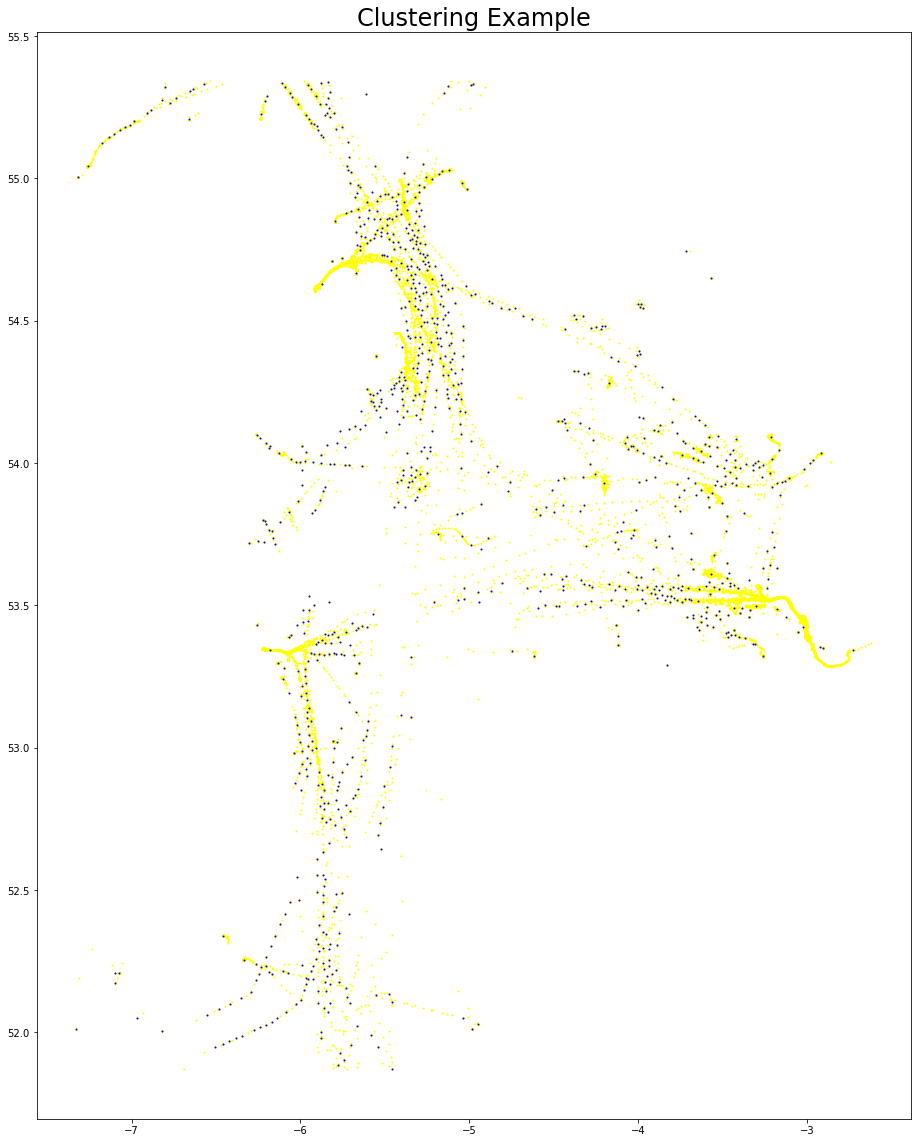

In [167]:

fig, ax = plt.subplots(figsize=(20, 20))
telemetry_gdf.plot(ax=ax, alpha=1, markersize=1, color='yellow')
cluster_gdf.plot(ax=ax, alpha=1, markersize=1, color='blue')
ax.set_title('Clustering Example', fontsize=24, loc='center')
plt.savefig("C:/Users/mhudgell/figures/local.png")
plt.show()